In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import * #import from vision to use the classification interpreter
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from timeseries import TimeSeriesItem, TimeSeriesList, UCRArchive
import hiddenlayer as hl
from scipy.signal import resample
from sklearn.cluster import KMeans
from sklearn.utils.linear_assignment_ import linear_assignment
from scipy.optimize import linear_sum_assignment
import sklearn.metrics

In [3]:
ucr = UCRArchive()

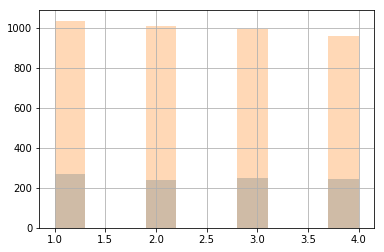

In [4]:
#https://github.com/michaal94/torch_DCEC

dataset_name = "TwoPatterns"
vc = ucr.category_distribution(dataset_name)

In [5]:
class Resample(PreProcessor):
    def process_one(self,item):
        return np.concatenate([item[[0]],resample(item[1:],96)]) if len(item) > 97 else item

In [6]:
src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0,processor=Resample())
valIdxs = np.random.choice(len(src.items),int(len(src.items)*0.3),replace=False)
data = src.split_by_idx(valIdxs)
data = data.label_from_col()
idxs = np.random.choice(len(data.x),size=len(data.x)//10,replace=False)
bs = min(64,len(data.x)//50)
data.x.items = data.train.x.items[idxs]
data.y.items = data.train.y.items[idxs]
data = data.databunch(bs=bs,num_workers=0)
len(data.train_ds)

C:\Users\lordn\Anaconda3\envs\fastai\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\lordn\Anaconda3\envs\fastai\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\lordn\Anaconda3\envs\fastai\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

350

In [7]:
src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0,processor=Resample())
dataF = src.split_by_idx(valIdxs)
dataF = dataF.label_from_col()
bs = min(64,len(dataF.x)//50)
dataF = dataF.databunch(bs=bs,num_workers=0)
len(dataF.train_ds)

3500

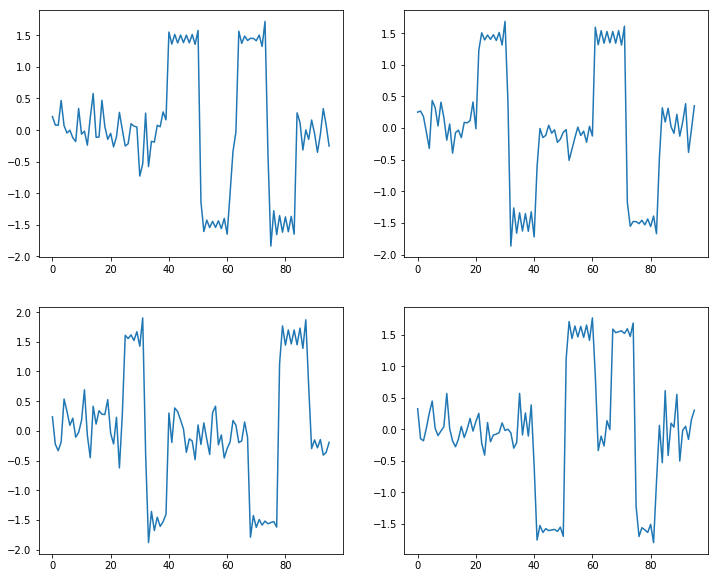

In [8]:
data.show_batch()

In [ ]:
class TSClassifier(torch.nn.Module):
    def __init__(self,seqLen,numClasses):
        super().__init__()
        self.conv = HeroResnet(3,3,12)
        self.out = create_head_1d(self.conv.nf,numClasses,ps=0.0)
              
    def forward(self,ts):
        ts = self.conv(ts.unsqueeze(1))[0].squeeze(-1)
        return self.out(ts)

In [ ]:
#Create a fastai learner
learn = Learner(data,TSClassifier(len(data.train_ds[0][0].data),data.train_ds.c),loss_func=F.cross_entropy,metrics=[accuracy])

In [ ]:
# Run one batch through the model to make sure the output size is correct
learn.model(next(iter(data.train_dl))[0]).size()

In [ ]:
#Learning rate finder
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.to_fp16();

In [ ]:
learn.fit_one_cycle(20,1e-3,wd=0.2)

In [12]:
src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0,processor=Resample())
dataAE = src.split_by_idx(valIdxs)
dataAE = dataAE.label_from_self()
dataAE = dataAE.databunch(bs=bs,num_workers=0)
len(dataAE.train_ds)

3500

In [13]:
src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0,return_index=True,processor=Resample())
dataC = src.split_by_idx(valIdxs)
dataC = dataC.label_from_col()
bs = min(64,len(dataC.x)//50)
dataC = dataC.databunch(bs=bs,num_workers=0)
len(dataF.train_ds)

3500

In [14]:
class ClusteringLayer(nn.Module):
    def __init__(self, in_features=10, out_features=10, alpha=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.weight = nn.Parameter(torch.zeros(self.out_features, self.in_features).cuda())
        self.weight = nn.init.xavier_uniform_(self.weight)
        
    def forward(self, x):
        norm_squared = torch.sum((x.unsqueeze(1) - self.weight)**2, 2)
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = (self.alpha + 1.0) / 2
        numerator = numerator**power
        return (numerator.t() / torch.sum(numerator, 1)).t()

    def extra_repr(self):
        return 'in_features={}, out_features={}, alpha={}'.format(
            self.in_features, self.out_features, self.alpha
        )

    def set_weight(self, tensor):
        #self.weight = nn.Parameter(tensor.cuda())
        with torch.no_grad():
            self.weight.copy_(tensor)

class AutoCluster(nn.Module):
    def __init__(self,numClasses,seqLen,latentDim):
        super().__init__()
        self.conv = HeroResnet(3,3,12)
        self.ls = torch.nn.Linear(self.conv.nf,latentDim)
        self.out = create_head_1d(latentDim,seqLen,lin_ftrs=[256,512],ps=0.0)
        self.softassign = ClusteringLayer(latentDim,numClasses)
        
       
    def getLS(self,ts):
        ts, _ = self.conv(ts.unsqueeze(1))
        ts = ts.squeeze(-1)
        ls = self.ls(ts)
        return ls
        
    def forward(self,ts):
        ots = ts
        ts, _ = self.conv(ts.unsqueeze(1))
        ts = ts.squeeze(-1)
        ls = self.ls(ts)
        
        return self.out(ls), self.softassign(ls), ots

In [15]:
def target_dist(batch: torch.Tensor) -> torch.Tensor:
    weight = (batch ** 2) / torch.sum(batch, 0)
    return (weight.t() / torch.sum(weight, 1)).t()

In [16]:
def ClusterLoss(pred,target):
    tar_dist = target_dist(pred).detach()
    return F.kl_div(torch.log(pred),tar_dist,reduction="batchmean")

In [17]:
class CombinedLoss(torch.nn.Module):
    def __init__(self,gamma=0.0,mse_scale=1.0):
        super().__init__()
        self.gamma = gamma
        self.mse_scale = mse_scale
    def forward(self,out,target):
        rP,cP,x = out
        tar_dist = target_dist(cP).detach()
        self.mse = self.mse_scale * F.mse_loss(rP,x)
        self.kld = self.gamma * F.kl_div(torch.log(cP),tar_dist,reduction="batchmean")
        return self.mse + self.kld

In [18]:
class CombinedLoss(torch.nn.Module):
    def __init__(self,gamma=0.0,mse_scale=1.0):
        super().__init__()
        self.gamma = gamma
        self.mse_scale = mse_scale
    def forward(self,out,labels,tar_dist):
        rP,cP,x = out
        #tar_dist = target_dist(cP).detach()
        self.mse = self.mse_scale * F.mse_loss(rP,x)
        self.kld = self.gamma * F.kl_div(torch.log(cP),tar_dist,reduction="batchmean")
        return self.mse + self.kld

In [19]:
class CombinedLossFake(torch.nn.Module):
    def __init__(self,gamma=0.0,mse_scale=1.0):
        super().__init__()
        self.gamma = gamma
        self.mse_scale = mse_scale
    def forward(self,out,labels,tar_dist):
        rP,cP,x = out

        self.mse = self.mse_scale * F.mse_loss(rP,x)
        self.kld = self.gamma * F.nll_loss(torch.log(cP),labels)
        return self.mse + self.kld

In [20]:
class ClusterAccuracy(LearnerCallback):
#     def on_epoch_begin(self, **kwargs):
#         self.pred, self.true = [],[]
        
#     def on_batch_end(self,last_output,last_target,**kwargs):
#         _,labels_pred,_ = last_output
#         last_target,_ = last_target
#         labels_pred = labels_pred.cpu().detach().numpy()
#         labels_true = last_target.cpu().detach().numpy()
#         labels_pred = np.argmax(labels_pred,axis=1)
#         self.pred.append(labels_pred)
#         self.true.append(labels_true)
    _order=-21
    def __init__(self,learn):
        super().__init__(learn)
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(["cluster_accuracy"])
        
    def on_epoch_end(self,**kwargs):
#         labels_pred = np.concatenate(self.pred)
#         labels_true = np.concatenate(self.true)
        self.learn.model.eval()
        dl = torch.utils.data.DataLoader(self.learn.data.train_ds,batch_size=64,collate_fn=data_collate)
        labels_pred, labels_true = [],[]
        
        with torch.no_grad():
            for (ts,idxs),labels in iter(dl):
                ts = ts.cuda()
                labels_pred.append(np.argmax(self.learn.model(ts)[1].cpu().detach().numpy(),axis=1))
                labels_true.append(labels.numpy())
        labels_pred = np.concatenate(labels_pred)
        labels_true = np.concatenate(labels_true)
        
        labels_true = labels_true.astype(np.int64)
        assert labels_pred.size == labels_true.size
        
        D = max(labels_pred.max(), labels_true.max()) + 1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(labels_pred.size):
            w[labels_pred[i], labels_true[i]] += 1
        ind = linear_assignment(w.max() - w)
        #self.metric = torch.tensor(sum([w[i, j] for i, j in ind]) * 1.0 / labels_pred.size)
        self.learn.recorder.add_metrics([torch.tensor(sum([w[i, j] for i, j in ind]) * 1.0 / labels_pred.size)])

In [21]:
class PrintLosses(LearnerCallback):
    _order=-20
    def __init__(self,learn):
        super().__init__(learn)
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(["mse","kld"])
    def on_epoch_end(self, **kwargs):
        self.learn.recorder.add_metrics([self.learn.loss_func.mse,self.learn.loss_func.kld])

In [22]:
class PDistCallback(LearnerCallback):   
    def on_epoch_begin(self,**kwargs):
        out = torch.zeros(len(self.learn.data.train_ds),self.learn.data.train_ds.c).cuda()
        self.learn.model.eval()
        dl = torch.utils.data.DataLoader(self.learn.data.train_ds,batch_size=64,collate_fn=data_collate)
        with torch.no_grad():
            for (ts,idxs),_ in iter(dl):
                ts = ts.cuda()
                idxs = idxs.cuda()
                out[idxs] = self.learn.model(ts)[1]
            self.tar_dist = target_dist(out).detach()
        self.learn.model.train()
        
    def on_batch_begin(self,last_input,last_target,**kwargs):
        ts, i = last_input
        return ts, (last_target,self.tar_dist[i])

In [23]:
dl = torch.utils.data.DataLoader(dataC.train_ds,batch_size=64,collate_fn=data_collate)

In [24]:
freqs = collections.defaultdict(int)
for (ts,idxs),_ in iter(dl):
    for i in idxs: freqs[i.item()] += 1
[(x,freqs[x]) for x in range(len(dataC.train_ds)) if freqs[x] != 1]

[]

In [25]:
learnCluster = Learner(dataC,AutoCluster(data.train_ds.c,96,12),loss_func=CombinedLoss(),opt_func=torch.optim.Adam,
                       callback_fns=[PDistCallback,ClusterAccuracy],bn_wd=False,train_bn=False)
# learnCluster = Learner(dataF,AutoCluster(data.train_ds.c,96,12),loss_func=CombinedLoss(),
#                        metrics=[ClusterAccuracy()],callback_fns=[PrintLosses])
learnCluster.split(split_model(learnCluster.model,[learnCluster.model.out,learnCluster.model.softassign]))

In [26]:
learnCluster.model(next(iter(dataF.train_dl))[0])[0].size()

torch.Size([64, 96])

In [27]:
learnCluster.fit_one_cycle(20,1e-2)

epoch,train_loss,valid_loss,cluster_accuracy
1,0.875119,0.786850,0.318000
2,0.624505,0.694592,0.318000
3,0.427971,0.432168,0.305429
4,0.334317,0.367883,0.312571
5,0.284862,0.304651,0.313714
6,0.255418,0.252459,0.308286
7,0.236922,0.224213,0.302286
8,0.219435,0.214527,0.302000
9,0.203856,0.191659,0.303143
10,0.193314,0.188343,0.304286


In [28]:
learnCluster.save("gamma0")

In [ ]:
learnCluster.load("gamma0");

In [29]:
learnCluster.model.eval()
out = []
classes = []
with torch.no_grad():
    for x,y in iter(dataF.train_dl):
        ls = learnCluster.model.getLS(x)
        out.append(ls)
        classes.append(y)
out = torch.cat(out).cpu().detach().numpy()
classes = torch.cat(classes).cpu().detach().numpy()

kmeans = KMeans(n_clusters=data.train_ds.c,n_init=20)
kmeans.fit_predict(out)
centroids = torch.tensor(kmeans.cluster_centers_)
learnCluster.model.softassign.set_weight(centroids)

In [30]:
learnCluster.model.eval()
dl = torch.utils.data.DataLoader(learnCluster.data.train_ds,batch_size=64,collate_fn=data_collate)
labels_pred, labels_true = [],[]

with torch.no_grad():
    for (ts,idxs),labels in iter(dl):
        ts = ts.cuda()
        labels_pred.append(np.argmax(learnCluster.model(ts)[1].cpu().detach().numpy(),axis=1))
        labels_true.append(labels.numpy())
labels_pred = np.concatenate(labels_pred)
labels_true = np.concatenate(labels_true)

labels_true = labels_true.astype(np.int64)
assert labels_pred.size == labels_true.size

D = max(labels_pred.max(), labels_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(labels_pred.size):
    w[labels_pred[i], labels_true[i]] += 1
ind = linear_assignment(w.max() - w)
#self.metric = torch.tensor(sum([w[i, j] for i, j in ind]) * 1.0 / labels_pred.size)
torch.tensor(sum([w[i, j] for i, j in ind]) * 1.0 / labels_pred.size)

tensor(0.2969)

In [31]:
learnCluster.loss_func.gamma = 1.0

In [32]:
learnCluster.loss_func.mse_scale = 0.0

In [ ]:
learnCluster.freeze()

In [ ]:
for p in learnCluster.model.out.parameters():
    p.requires_grad_(False)

In [ ]:
learnCluster.lr_find()
learnCluster.recorder.plot()

In [33]:
learnCluster.model.softassign.weight

Parameter containing:
tensor([[ 0.2952,  0.2585, -0.4761, -0.0807,  0.0923, -0.4316,  0.1581,  0.2505,
          0.2471,  0.6355, -0.6958, -0.8610],
        [-0.0623,  0.2406, -0.1644, -0.6068, -0.8902,  0.1071, -0.1337,  0.2646,
          0.4714, -0.1072, -0.3242, -0.6625],
        [ 0.2567, -0.3663,  0.0273,  0.0549, -1.0159, -0.7919,  0.1140,  0.1471,
         -0.1486, -0.0302, -0.4639, -0.5629],
        [-0.0471,  0.0493, -0.1540,  0.0444, -0.8487, -0.1247, -0.3219,  0.9612,
         -0.3335,  0.1899, -0.5393, -1.3995]], device='cuda:0',
       requires_grad=True)

In [34]:
learnCluster.model.softassign.weight

Parameter containing:
tensor([[ 0.2952,  0.2585, -0.4761, -0.0807,  0.0923, -0.4316,  0.1581,  0.2505,
          0.2471,  0.6355, -0.6958, -0.8610],
        [-0.0623,  0.2406, -0.1644, -0.6068, -0.8902,  0.1071, -0.1337,  0.2646,
          0.4714, -0.1072, -0.3242, -0.6625],
        [ 0.2567, -0.3663,  0.0273,  0.0549, -1.0159, -0.7919,  0.1140,  0.1471,
         -0.1486, -0.0302, -0.4639, -0.5629],
        [-0.0471,  0.0493, -0.1540,  0.0444, -0.8487, -0.1247, -0.3219,  0.9612,
         -0.3335,  0.1899, -0.5393, -1.3995]], device='cuda:0',
       requires_grad=True)

In [36]:
learnCluster.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,cluster_accuracy
1,0.011746,0.189061,0.293429
2,0.045316,0.588925,0.287143
3,0.101619,1.109880,0.294286
4,0.161184,1.580139,0.302286
5,0.139757,2.012389,0.303429
6,0.137967,2.268817,0.295714
7,0.127375,2.432665,0.297714
8,0.103086,2.599363,0.297143
9,0.090249,2.680442,0.297429
10,0.081274,2.708048,0.298286


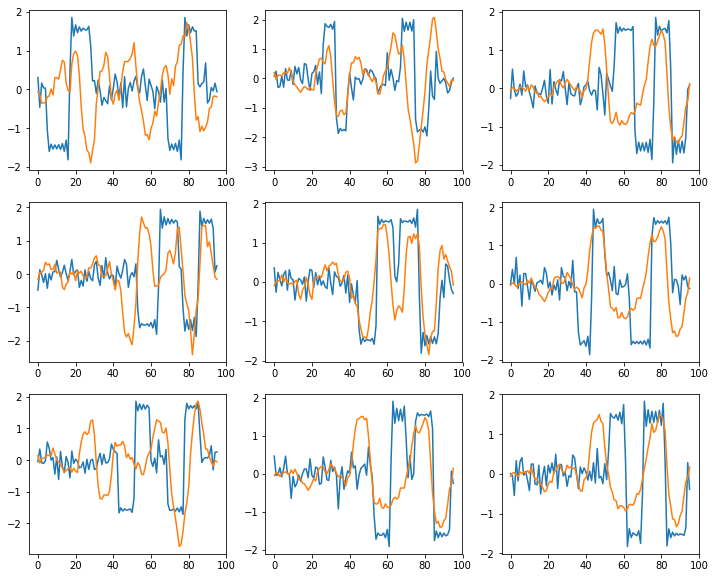

In [37]:
learnClusterShow = Learner(dataAE,learnCluster.model,loss_func=CombinedLoss())
learnClusterShow.show_results(DatasetType.Train,rows=9)

In [ ]:
learnDT = Learner(data,TSClassifier(len(data.train_ds[0][0].data),data.train_ds.c),loss_func=F.cross_entropy,metrics=[accuracy],
                 callback_fns=BnFreeze,bn_wd=False,train_bn=False)
learnDT.split(split_model(learnDT.model,[*learnDT.model.conv.split_groups,learnDT.model.out]))

In [ ]:
learnDT.model.conv.load_state_dict(learnAE.model.conv.state_dict())

In [ ]:
learnDT.lr_find()
learnDT.recorder.plot()

In [ ]:
learnDT.freeze_to(-1)
learnDT.fit_one_cycle(10,1e-2)

In [ ]:
learnDT.unfreeze()
learnDT.fit_one_cycle(10,slice(1e-5,1e-3))

In [9]:
def deconv_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose1d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    #conv = conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append(nn.BatchNorm1d(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)


def create_head_1d(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

def conv1d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv1d:
    "Create and initialize `nn.Conv1d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

def _bn1d(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm1d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv1d(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn1d(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv1d(ni, nf, ks, stride))

class ResBlock(torch.nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(ni)
        self.conv1 = conv1d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv1d(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv1d(ni, nf, 1, stride) if ni != nf or stride > 1 else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet1d(nn.Module):
    "Wide ResNet with `num_groups` and a width of `k`."
    def __init__(self, num_groups:int, N:int, k:int=1, drop_p:float=0.0, start_nf:int=16,maxY=20.0):
        super().__init__()
        self.maxY = maxY
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)
        
        
        layers = [conv1d(1, n_channels[0], 3, 1)]  # conv1
        self.split_groups = [layers[-1]] 
        
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], ResBlock, (1 if i==0 else 2), drop_p)
            self.split_groups.append(layers[-N])
            
        layers += [nn.BatchNorm1d(n_channels[-1]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool1d(1),
                   Flatten()]
        #self.split_groups.append(layers[-1])
        self.nf = n_channels[-1]
        self.features = nn.Sequential(*layers)

    def forward(self, x):
        #x = x.unsqueeze(1)
        return self.features(x)

In [10]:
class HeroResnet(nn.Module):
    def __init__(self, num_groups:int, N:int, k:int=1, drop_p:float=0.0, start_nf:int=16):
        super().__init__()
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)
            
        self.layer0 = conv1d(1,n_channels[0],3,1)
        self.split_groups = [self.layer0]
               
        groups = [nn.Sequential(*_make_group(N,n_channels[i],n_channels[i+1],ResBlock,2,drop_p)) for i in range(num_groups)]
       
        self.groups = nn.ModuleList(groups)
        for g in self.groups: self.split_groups.append(g)
        
        self.out = nn.Sequential(nn.BatchNorm1d(n_channels[-1]),
                                 nn.ReLU(inplace=True),
                                 nn.AdaptiveAvgPool1d(1))               
        
        self.split_groups.append(self.out)
        self.nf = n_channels[-1]
        
    def forward(self, x):
        bs = x.shape[0]
        actvns = [self.layer0(x)]
        
        for l in self.groups:
            actvns.append(l(actvns[-1]))

        return self.out(actvns[-1]), actvns
        

In [11]:
class SidekickResnet(nn.Module):
    def __init__(self, num_classes:int, num_groups:int, N:int, k:int=1, hero_k:int=1, drop_p:float=0.0, start_nf:int=16, start_nf_hero:int=16):
        super().__init__()
        n_channels = [start_nf]
        
        self.hero = HeroResnet(num_groups,N,hero_k,drop_p,start_nf_hero)
        
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)
            
        n_channels_hero = [start_nf_hero]
        for i in range(num_groups): n_channels_hero.append(start_nf_hero*(2**i)*hero_k)   
            
        self.layer0 = conv1d(1,n_channels[0],3,1)
        
        groups = [nn.Sequential(*_make_group(N,n_channels[i]+n_channels_hero[i],n_channels[i+1],ResBlock,2,drop_p)) for i in range(num_groups)]
        
        self.groups = nn.ModuleList(groups)
        
        self.avg = nn.Sequential(nn.BatchNorm1d(n_channels[-1]),
                                 nn.ReLU(inplace=True),
                                 nn.AdaptiveAvgPool1d(1))
               
        self.out = create_head_1d(n_channels[-1]+n_channels_hero[-1],num_classes,ps=0.1)
               
    def forward(self,ts):
        ts = ts.unsqueeze(1)
        pt, actvns = self.hero(ts)
        
        x = self.layer0(ts)
        for l,a in zip(self.groups,actvns):
            x = l(torch.cat([x,a],dim=1))
            
        x = torch.cat([self.avg(x),pt],dim=1).squeeze(-1)
        #x = F.dropout(x,p=0.5)
        return self.out(x)

In [38]:
learn = Learner(data,SidekickResnet(data.train_ds.c,3,3,6,12), loss_func=F.cross_entropy,metrics=[accuracy],callback_fns=BnFreeze,bn_wd=False,train_bn=False)
learn.split(split_model(learn.model,[learn.model.hero,learn.model.layer0,learn.model.avg,learn.model.out]))

In [ ]:
learn.model(next(iter(data.train_dl))[0]).size()

In [39]:
#learn.model.hero.load_state_dict(learnAE.model.conv.state_dict())
learn.model.hero.load_state_dict(learnCluster.model.conv.state_dict())
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(20,1e-3,wd=0.2)

epoch,train_loss,valid_loss,accuracy
1,1.417627,1.386973,0.236667
2,1.244313,1.385799,0.237333
3,1.060321,1.374207,0.241333
4,0.878290,1.324920,0.278667
5,0.716059,1.189909,0.556000
6,0.582396,0.928027,0.858000
7,0.478520,0.609023,0.951333
8,0.398958,0.394913,0.944667
9,0.338070,0.236379,0.981333
10,0.288658,0.165956,0.981333
